# Face Recognition with SphereFace

Paper: https://arxiv.org/abs/1704.08063

Repo: https://github.com/wy1iu/sphereface

In [1]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
#We are going to use deepface to detect and align faces
#Repo: https://github.com/serengil/deepface
#!pip install deepface
from deepface.commons import functions

Using TensorFlow backend.


### Pre-trained model

In [3]:
#Structure: https://github.com/wy1iu/sphereface/blob/master/train/code/sphereface_deploy.prototxt
#Weights: https://drive.google.com/open?id=0B_geeR2lTMegb2F6dmlmOXhWaVk

model = cv2.dnn.readNetFromCaffe("sphereface_deploy.prototxt", "sphereface_model.caffemodel")

In [4]:
#SphereFace input shape. You can verify this in the prototxt.
input_shape = (112, 96)

### Common functions

In [5]:
#Similarity metrics tutorial: https://sefiks.com/2018/08/13/cosine-similarity-in-machine-learning/

def findCosineDistance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

### Data set

In [6]:
# Master.csv: https://github.com/serengil/deepface/blob/master/tests/dataset/master.csv
# Images: https://github.com/serengil/deepface/tree/master/tests/dataset
df = pd.read_csv("../deepface/tests/dataset/master.csv")

In [7]:
df.head()

,file_x,file_y,Decision
0,img20.jpg,img21.jpg,Yes
1,img16.jpg,img17.jpg,Yes
2,img3.jpg,img12.jpg,Yes
3,img22.jpg,img23.jpg,Yes
4,img24.jpg,img25.jpg,Yes


In [8]:
euclidean_distances = []; cosine_distances = []
for index, instance in tqdm(df.iterrows(), total = df.shape[0]):
    img1_path = instance["file_x"]
    img2_path = instance["file_y"]
    target_label = instance["Decision"]
    
    #----------------------------------
    
    #detect and align
    img1 = functions.preprocess_face("../deepface/tests/dataset/%s" % (img1_path), target_size=input_shape)[0]
    img2 = functions.preprocess_face("../deepface/tests/dataset/%s" % (img2_path), target_size=input_shape)[0]
    
    #----------------------------------
    #reshape images to expected shapes
    
    img1_blob = cv2.dnn.blobFromImage(img1)
    img2_blob = cv2.dnn.blobFromImage(img2)
    
    if img1_blob.shape != (1, 3, 96, 112):
        raise ValueError("img shape must be (1, 3, 96, 112) but it has a ", img1_blob.shape," shape")
    
    #----------------------------------
    #representation
    
    model.setInput(img1_blob)
    img1_representation = model.forward()[0]

    model.setInput(img2_blob)
    img2_representation = model.forward()[0]
    
    #----------------------------------
    
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
    euclidean_distances.append(euclidean_distance)
    
    cosine_distance = findCosineDistance(img1_representation, img2_representation)
    cosine_distances.append(cosine_distance)

100%|██████████| 300/300 [04:18<00:00,  1.16it/s]


In [9]:
df['euclidean'] = euclidean_distances
df['cosine'] = cosine_distances

In [10]:
df.head()

,file_x,file_y,Decision,euclidean,cosine
0,img20.jpg,img21.jpg,Yes,15.020055,0.359611
1,img16.jpg,img17.jpg,Yes,15.546786,0.378807
2,img3.jpg,img12.jpg,Yes,19.571346,0.674539
3,img22.jpg,img23.jpg,Yes,15.902503,0.397023
4,img24.jpg,img25.jpg,Yes,18.453997,0.608696


### Visualize distributions

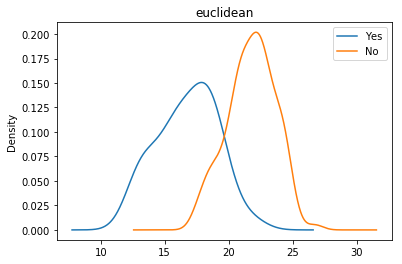

In [11]:
df[df.Decision == "Yes"]['euclidean'].plot(kind='kde', title = 'euclidean', label = 'Yes', legend = True)
df[df.Decision == "No"]['euclidean'].plot(kind='kde', title = 'euclidean', label = 'No', legend = True)
plt.show()

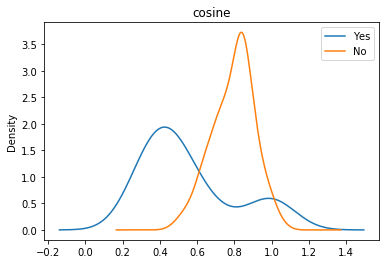

In [12]:
df[df.Decision == "Yes"]['cosine'].plot(kind='kde', title = 'cosine', label = 'Yes', legend = True)
df[df.Decision == "No"]['cosine'].plot(kind='kde', title = 'cosine', label = 'No', legend = True)
plt.show()

### Find the best threshold

In [13]:
#Repo: https://github.com/serengil/chefboost
#!pip install chefboost
from chefboost import Chefboost as chef
config = {'algorithm': 'C4.5'}

In [15]:
df[['euclidean', 'Decision']].head()

,euclidean,Decision
0,15.020055,Yes
1,15.546786,Yes
2,19.571346,Yes
3,15.902503,Yes
4,18.453997,Yes


In [16]:
euclidean_tree = chef.fit(df[['euclidean', 'Decision']].copy(), config)

{'algorithm': 'C4.5', 'enableMultitasking': False, 'num_of_weak_classifier': 4, 'num_of_trees': 5, 'enableRandomForest': False, 'learning_rate': 1, 'epochs': 10, 'enableAdaboost': False, 'enableGBM': False, 'enableParallelism': False}
C4.5  tree is going to be built...
Accuracy:  94.33333333333333 % on  300  instances
finished in  2.584498882293701  seconds


In [17]:
cosine_tree = chef.fit(df[['cosine', 'Decision']].copy(), config)

{'algorithm': 'C4.5', 'enableMultitasking': False, 'num_of_weak_classifier': 4, 'num_of_trees': 5, 'enableRandomForest': False, 'learning_rate': 1, 'epochs': 10, 'enableAdaboost': False, 'enableGBM': False, 'enableParallelism': False}
C4.5  tree is going to be built...
Accuracy:  93.66666666666667 % on  300  instances
finished in  3.1745662689208984  seconds


In [18]:
#stored in outputs/rules
euclidean_threshold = 17.212238311767578 #euclidean
cosine_threshold = 0.4668717384338379 #cosine

### Predictions

In [19]:
df['prediction_by_euclidean'] = 'No'
df['prediction_by_cosine'] = 'No'

In [20]:
df.loc[df[df['euclidean'] <= euclidean_threshold].index, 'prediction_by_euclidean'] = 'Yes'
df.loc[df[df['cosine'] <= cosine_threshold].index, 'prediction_by_cosine'] = 'Yes'

In [62]:
df.sample(5)

,file_x,file_y,Decision,euclidean,cosine,prediction_by_euclidean,prediction_by_cosine
14,img2.jpg,img6.jpg,Yes,12.469130,0.269654,Yes,Yes
271,img2.jpg,img9.jpg,No,20.052036,0.627870,No,No
295,img15.jpg,img9.jpg,No,24.117523,0.900087,No,No
31,img7.jpg,img11.jpg,Yes,17.007257,0.504744,Yes,No
216,img24.jpg,img15.jpg,No,22.619598,0.893417,No,No


In [22]:
euclidean_positives = 0; cosine_positives = 0
for index, instance in df.iterrows():
    target = instance['Decision']
    prediction_by_euclidean = instance['prediction_by_euclidean']
    prediction_by_cosine = instance['prediction_by_cosine']
    
    if target == prediction_by_euclidean:
        euclidean_positives = euclidean_positives + 1
    
    if target == prediction_by_cosine:
        cosine_positives = cosine_positives + 1

In [23]:
print("Accuracy (euclidean): ",round(100 * euclidean_positives/df.shape[0], 2))
print("Accuracy (cosine): ",round(100 * cosine_positives/df.shape[0], 2))

Accuracy (euclidean):  94.33
Accuracy (cosine):  93.67


### Production

In [24]:
def verifyFaces(img1_path, img2_path):
    
    print("Verify ",img1_path," and ",img2_path)
    
    #------------------------------------
    
    #detect and align
    img1 = functions.preprocess_face(img1_path, target_size=input_shape)[0]
    img2 = functions.preprocess_face(img2_path, target_size=input_shape)[0]
    
    img1_blob = cv2.dnn.blobFromImage(img1)
    img2_blob = cv2.dnn.blobFromImage(img2)

    #------------------------------------

    #representation
    model.setInput(img1_blob)
    img1_representation = model.forward()[0]

    model.setInput(img2_blob)
    img2_representation = model.forward()[0]
    
    #------------------------------------
    
    #verify
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)

    print("Found euclidean distance is ",euclidean_distance," whereas required threshold is ",euclidean_threshold)

    fig = plt.figure()

    ax1 = fig.add_subplot(1,2,1)
    plt.imshow(img1[:,:,::-1])
    plt.axis('off')

    ax2 = fig.add_subplot(1,2,2)
    plt.imshow(img2[:,:,::-1])
    plt.axis('off')

    plt.show()

    if euclidean_distance <= euclidean_threshold:
        print("they are same person")
    else:
        print("they are not same person")

### True positive examples

Verify  ../deepface/tests/dataset/img1.jpg  and  ../deepface/tests/dataset/img2.jpg
Found euclidean distance is  17.212238  whereas required threshold is  17.212238311767578


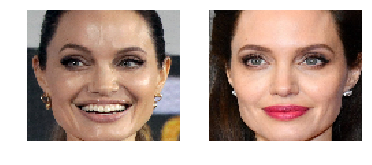

they are same person


In [25]:
verifyFaces("../deepface/tests/dataset/img1.jpg", "../deepface/tests/dataset/img2.jpg")

Verify  ../deepface/tests/dataset/img54.jpg  and  ../deepface/tests/dataset/img3.jpg
Found euclidean distance is  14.307708  whereas required threshold is  17.212238311767578


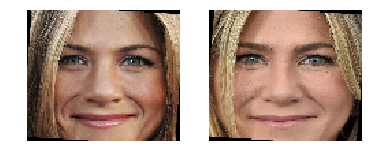

they are same person


In [26]:
verifyFaces("../deepface/tests/dataset/img54.jpg", "../deepface/tests/dataset/img3.jpg")

Verify  ../deepface/tests/dataset/img42.jpg  and  ../deepface/tests/dataset/img45.jpg
Found euclidean distance is  16.629126  whereas required threshold is  17.212238311767578


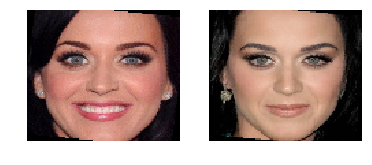

they are same person


In [27]:
verifyFaces("../deepface/tests/dataset/img42.jpg", "../deepface/tests/dataset/img45.jpg")

Verify  ../deepface/tests/dataset/img9.jpg  and  ../deepface/tests/dataset/img49.jpg
Found euclidean distance is  16.64627  whereas required threshold is  17.212238311767578


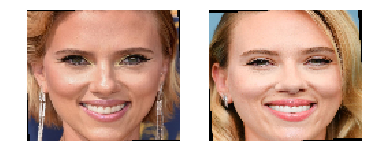

they are same person


In [28]:
verifyFaces("../deepface/tests/dataset/img9.jpg", "../deepface/tests/dataset/img49.jpg")

### True negative examples

Verify  ../deepface/tests/dataset/img1.jpg  and  ../deepface/tests/dataset/img3.jpg
Found euclidean distance is  24.375658  whereas required threshold is  17.212238311767578


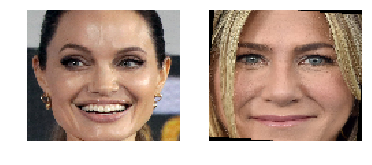

they are not same person


In [29]:
verifyFaces("../deepface/tests/dataset/img1.jpg", "../deepface/tests/dataset/img3.jpg")

Verify  ../deepface/tests/dataset/img1.jpg  and  ../deepface/tests/dataset/img45.jpg
Found euclidean distance is  20.676226  whereas required threshold is  17.212238311767578


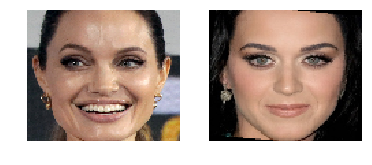

they are not same person


In [30]:
verifyFaces("../deepface/tests/dataset/img1.jpg", "../deepface/tests/dataset/img45.jpg")

Verify  ../deepface/tests/dataset/img1.jpg  and  ../deepface/tests/dataset/img49.jpg
Found euclidean distance is  19.667625  whereas required threshold is  17.212238311767578


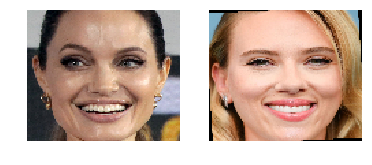

they are not same person


In [31]:
verifyFaces("../deepface/tests/dataset/img1.jpg", "../deepface/tests/dataset/img49.jpg")